These exercises were completed as part of DataCamp's "Advanced Deep Learning with Keras" course.

# The Keras Functional API
Here, you'll become familiar with the basics of the Keras functional API. You'll build a simple functional network using functional building blocks, fit it to data, and make predictions.

In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Subtract, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
#pip install graphviz pip install pydot pydotplus graphviz

In [3]:
plt.rcParams['figure.figsize'] = (8, 8)

#### The simplest model
First, we'll build a super-simple model using the Keras Functional API, just to demonstrate syntax as well as structure of the model. After that we'll start getting into some of the finer complexities.

In [4]:
# Create an input layer of shape 1
input_tensor = Input(shape=(1,))

In [5]:
# Dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

2022-01-19 15:59:05.707676: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-19 15:59:05.707995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Create a dense layer and connect the dense layer to the input_tensor in one step
# Note that we did this in 2 steps in the previous exercise, but are doing it in one step now
output_tensor = Dense(1)(input_tensor)

All together in one go, with `plot_model`:

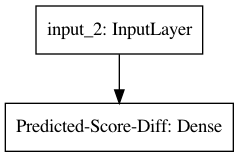

In [7]:
input_tensor = Input(shape=(1,))
output_layer = Dense(1, name = 'Predicted-Score-Diff')
output_tensor = output_layer(input_tensor)
model = Model(input_tensor, output_tensor)
plot_model(model, to_file = 'model.png')

In [11]:
games_tourney = pd.read_csv('basketball_data/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [12]:
games_tourney_train, games_tourney_test = train_test_split(games_tourney, test_size=0.3)

In [13]:
input_tensor = Input(shape=(1, ))
output_tensor = Dense(1)(input_tensor)

model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [14]:
model.fit(games_tourney_train['seed_diff'], games_tourney_train['score_diff'],
          epochs=1,
          batch_size=128,
          validation_split=0.1,
          verbose=True)

2022-01-19 16:37:31.932175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


21/21 [==============================] - 0s 7ms/step - loss: 12.4358 - val_loss: 12.5996


#### Evaluate the model on a test set

In [15]:
# Load the X variable from the test data
X_test = games_tourney_test['seed_diff']

# Load the y variable from the test data
y_test = games_tourney_test['score_diff']

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test, verbose=False))

12.137136459350586


#### Categorical embeddings
* **Categorical embeddings** are an advanced type of layer only available in deep learning libraries and are extremely useful for dealing with high cardinality categorical data. **Cardinality** refers to the uniqueness of data values contained in a particular column ([see here](https://en.wikipedia.org/wiki/Cardinality_(SQL_statements)) for more details).
* **Embedding layers** are also very useful for dealing with text data (such as in Word2vec models).

<img src='data/embedding_layer.png' width="600" height="300" align="center"/>

To model these teams in the basketball data, you'll use a very simple model that learns a "strength" rating for each team and uses those ratings to make predictions. TO map the integer team IDs to a decimal rating, we will use an embedding layer, as illustrated in the image above.

Because each team is represented as a single integer, the `input_length` will be `1`. However, since there are a total of 10,887 unique teams n the dataset, the input dimension (`input_dim`) of the embedding layer is `10887`. Likewise, because we want to produce a single team strength rating, the output dimension (`output_dim` will be `1`). Don't forget to name your layer, so that we can easily find it when looking at the model summary and/or plot.

```
input_tensor = Input(shape=(1,))
n_teams = 10887
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1
                        output_dim=1,
                        name='Team-Strength-Lookup')
embed_tensor = embed_layer(input_tensor)   
```

In [20]:
games_season = pd.read_csv('basketball_data/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [21]:
# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')
                        
# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')                                        

**The model will be reusable, so you can use it in two places in your final model.**

#### Shared layers
Create a shared layer using the team strength embedding model you just made above.

<img src='data/shared_layer.png' width="600" height="300" align="center"/>

#### Define two inputs
Define two input layers for the two teams in your model. This allows you to specify later in the model how the data from each team will be used differently.

In [22]:
# Input layer for team 1
team_in_1 = Input(shape=(1, ), name='Team-1-In')
# Also possible: team_in_1 = Input((1,), name="Team-1-In")

# Separate input layer for team 2
team_in_2 = Input(shape=(1, ), name='Team-2-In')
# Also possible: team_in_2 = Input((1,), name="Team-2-In")

#### Lookup both inputs in the same model 
Now that you have a team strength model and an input layer for each team, you can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

In this dataset, you have 10,888 unique teams. You want to learn a strength rating for each team, such that if any pair of teams plays each other, you can predict the score, even if those two teams have never played before. Furthermore, you want the strength rating to be the same, regardless of whether the team is the home team or the away team.

In [23]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Now your model knows how strong each team is.

#### Merge layers
Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game. Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game.



In [25]:
# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

#### Model using two inputs and one output
Now that you have your two inputs (team id 1 and team id 2) and output (score difference), you can wrap them up in a model so you can use it later for fitting to data and evaluating on new data.

In [26]:
# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

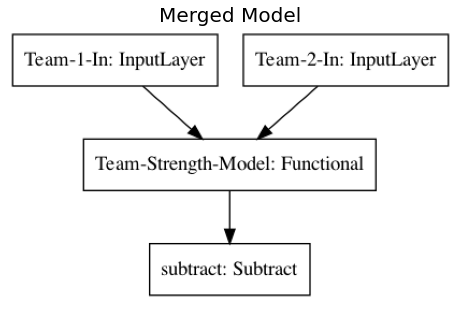

In [31]:
plot_model(model, to_file='data/embedding_shared_merge_model.png')

data = plt.imread('data/embedding_shared_merge_model.png')
plt.title("Merged Model", fontsize=20)
plt.axis('off')
plt.imshow(data)

Now your model is finalized and ready to fit to data.

#### Fit the model to the regular season training data

Now that you've defined a complete team strength model, you can fit it to the basketball data!

In [32]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season.score_diff,
          epochs=1,
          batch_size=2048,
          validation_split=0.1,
          verbose=True)

138/138 [==============================] - 1s 2ms/step - loss: 12.0955 - val_loss: 11.8382


#### Evaluate the model on the tournament test data
In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that your model is not overfitting.

In [33]:
games_tourney = pd.read_csv('basketball_data/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [34]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=False))

11.680545806884766


## Multiple input models with Keras
Now, you will extend your 2-input model to 3 inputs, and learn how to use Keras' summary and plot functions to understand the parameters and topology of your neural networks.

#### Make an input layer for 'home vs. away'
Now you will make an improvement to the model you just created for regular season games. You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.

This model will have three inputs:`team_id_1`, `team_id_2`, and `home`. The team IDs will be integers that you look up in your team strength model from the previous chapter, and `home` will be a binary variable, `1` if `team_1` is playing at home, `0` if they are not.

In [36]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [39]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [40]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [41]:
# Fit the model to the games_season dataset
model.fit([games_season.team_1, games_season.team_2, games_season.home],
          games_season.score_diff,
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney.team_1, games_tourney.team_2, games_tourney.home], 
                      games_tourney.score_diff, verbose=False))

138/138 [==============================] - 1s 2ms/step - loss: 12.1974 - val_loss: 11.9214
11.688822746276855


#### Model summaries

In [42]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Functional (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                      

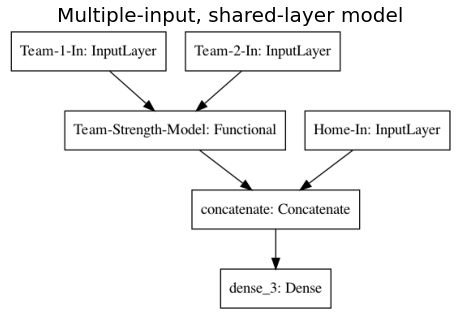

In [45]:
# Plot the model
plot_model(model, to_file='data/model.png')

# Display the image
data = plt.imread('data/model.png')
plt.imshow(data)
plt.title('Multiple-input, shared-layer model', fontsize=20)
plt.axis('off')
plt.show()

### Stacking models
You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [46]:
# Predict
games_tourney['pred'] = model.predict([games_tourney.team_1, 
                                       games_tourney.team_2, 
                                       games_tourney.home])

#### Create an input layer with multiple columns
In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

Now you have three numeric columns in the tournament dataset: `seed_diff`, `home'`, and `pred`. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

This model should have a single output to predict the tournament game score difference.

In [47]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

#### Fit the model
Now that you've enriched the tournament dataset and built a model to make use of the new data, fit that model to the tournament data.

First split the tournament games into a training set and a test set. The tournament games before 2010 should be in the training set, and the ones after 2010 should be in the test set.

In [48]:
games_tourney_train = games_tourney[games_tourney['season'] <= 2010]
games_tourney_test = games_tourney[games_tourney['season'] > 2010]

In [49]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

103/103 [==============================] - 0s 556us/step - loss: 8.9994


#### Evaluate the model
Now that you've fit your model to the tournament training data, evaluate it on the tournament test data.

In [51]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
               games_tourney_test.score_diff, verbose=False))

9.183992385864258


#### Simple two-output model
In this exercise, you will use the tournament data to build one model that makes two predictions: the scores of both teams in a given game. Your inputs will be the seed difference of the two teams, as well as the predicted score difference from the model you built in chapter 3.

The output from your model will be the predicted score for team 1 as well as team 2. This is called "multiple target regression": one model making more than one prediction.

In [66]:
# Count the unique number of teams
n_teams = np.unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

In [67]:
# Create an input layer for the team ID
teamid_in = Input(shape=(1, ))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

In [68]:
# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, 
# then add a Dense layer

out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [69]:
# Make a model
p_model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
p_model.compile(optimizer='adam', loss='mean_absolute_error')

In [70]:
# Fit the model to the games_season dataset
p_model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1, verbose=True, validation_split=0.1, batch_size=2048)


138/138 [==============================] - 1s 2ms/step - loss: 12.0843 - val_loss: 12.2287


In [71]:
games_tourney['pred'] = p_model.predict([games_tourney['team_1'], 
                                       games_tourney['team_2'], 
                                       games_tourney['home']])

In [72]:
games_tourney['pred']

0       0.058947
1       0.062208
2       0.056814
3       0.102789
4       0.110866
          ...   
4229    0.271721
4230    0.282170
4231    0.282081
4232    0.281768
4233    0.282113
Name: pred, Length: 4234, dtype: float32

In [73]:
games_tourney_train = games_tourney[games_tourney['season'] <= 2010]
games_tourney_test = games_tourney[games_tourney['season'] > 2010]

In [74]:
model.fit(games_tourney_train[['seed_diff', 'pred']], 
          games_tourney_train[['score_1', 'score_2']],
          verbose=False,
          epochs=10000,
          batch_size=256);

In [75]:
model.get_weights()

[array([[ 0.5865494, -0.6571272],
        [32.992516 , 28.51089  ]], dtype=float32),
 array([67.62437, 68.10281], dtype=float32)]

In [76]:
# Print the column means of the training data
print(games_tourney_train.mean())

season        1997.548544
team_1        5560.890777
team_2        5560.890777
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.786711
score_2         71.786711
won              0.500000
pred             0.099920
dtype: float64


In [77]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']], 
                     games_tourney_test[['score_1', 'score_2']],
                     verbose=False))

9.634602546691895


### Single model for classification and regression
Now you will create a different kind of 2-output model. This time, you will predict the score difference, instead of both team's scores and then you will predict the probability that team 1 won the game. This is a pretty cool model: it is going to do both classification and regression!

In this model, turn off the bias, or intercept for each layer. Your inputs (seed difference and predicted score difference) have a mean of very close to zero, and your outputs both have means that are close to zero, so your model shouldn't need the bias term to fit the data well.

In [78]:
input_tensor = Input(shape=(2, ))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output(use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

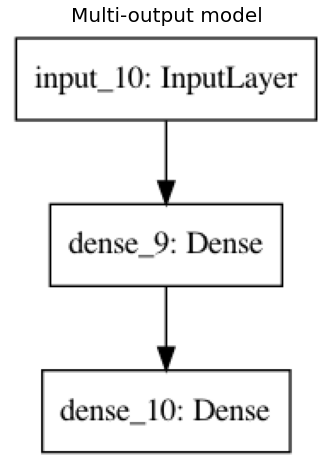

In [79]:
plot_model(model, to_file='data/multi_output_model.png')

data = plt.imread('data/multi_output_model.png')
plt.title("Multi-output model", fontsize=20)
plt.axis('off')
plt.imshow(data)

In [80]:
from tensorflow.keras.optimizers import Adam

In [81]:
# Compile the model with 2 losses and the Adam optimizer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(lr=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=20,
          verbose=True,
          batch_size=16384)

Epoch 1/20
1/1 [==============================] - 0s 319ms/step - loss: 17.9134 - dense_9_loss: 13.9781 - dense_10_loss: 3.9353
Epoch 2/20
1/1 [==============================] - 0s 2ms/step - loss: 17.7688 - dense_9_loss: 13.9316 - dense_10_loss: 3.8372
Epoch 3/20
1/1 [==============================] - 0s 2ms/step - loss: 17.6256 - dense_9_loss: 13.8853 - dense_10_loss: 3.7403
Epoch 4/20
1/1 [==============================] - 0s 2ms/step - loss: 17.4836 - dense_9_loss: 13.8391 - dense_10_loss: 3.6445
Epoch 5/20
1/1 [==============================] - 0s 3ms/step - loss: 17.3428 - dense_9_loss: 13.7929 - dense_10_loss: 3.5500
Epoch 6/20
1/1 [==============================] - 0s 2ms/step - loss: 17.2033 - dense_9_loss: 13.7467 - dense_10_loss: 3.4566
Epoch 7/20
1/1 [==============================] - 0s 2ms/step - loss: 17.0650 - dense_9_loss: 13.7006 - dense_10_loss: 3.3645
Epoch 8/20
1/1 [==============================] - 0s 3ms/step - loss: 16.9283 - dense_9_loss: 13.6547 - dense_10_los

In [82]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[-0.311786 ],
       [ 0.1304859]], dtype=float32), array([[1.2813777]], dtype=float32)]
season        1997.548544
team_1        5560.890777
team_2        5560.890777
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.786711
score_2         71.786711
won              0.500000
pred             0.099920
dtype: float64


In [83]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


In [84]:
# Evaluate the model on new data
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]], verbose=False))

[14.480280876159668, 12.407909393310547, 2.072371006011963]


Turns out you can have your cake and eat it too! This model is both a good regressor and a good classifier!